# AVTM (Avantis Total Equity Markets ETF) Factor Analysis

**Fund:** Avantis Total Equity Markets ETF (AVTM)  
**Launched:** February 2, 2026  
**Expense Ratio:** 0.22%  
**Strategy:** Actively managed fund-of-funds investing in Avantis ETFs across US, developed, and emerging markets with value/size factor tilts

Since AVTM launched very recently (~5 trading days), we use:
1. **AVGE** (Avantis All Equity Markets ETF) as the closest proxy with full history
2. **Weighted-average analysis** of underlying Avantis ETFs to estimate AVTM factor loadings
3. **Individual ETF regressions** across CAPM, FF3, FF5, and Carhart models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from portfolio_analysis.data import DataLoader
from portfolio_analysis.factors import (
    FactorDataLoader,
    FactorRegression,
    FactorAttribution,
    FactorVisualization,
)

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'

print('Imports loaded successfully.')

Imports loaded successfully.


## 1. Data Loading

Fetch price data for all Avantis ETFs that AVTM likely holds (based on AVGE's known allocation) plus Fama-French factor data.

In [2]:
# AVGE holdings (as of Feb 2026) - best proxy for AVTM allocation
AVGE_HOLDINGS = {
    'AVUS': 0.4192,   # U.S. Equity
    'AVLV': 0.1516,   # U.S. Large Cap Value
    'AVDE': 0.1113,   # International Equity
    'AVEM': 0.0657,   # Emerging Markets Equity
    'AVIV': 0.0570,   # International Large Cap Value
    'AVUV': 0.0361,   # U.S. Small Cap Value
    'AVES': 0.0352,   # Emerging Markets Value
    'AVSC': 0.0342,   # U.S. Small Cap Equity
    'AVRE': 0.0275,   # Real Estate
    'AVDV': 0.0131,   # International Small Cap Value
}

START_DATE = '2020-01-01'
END_DATE = '2026-02-07'

all_tickers = list(set(['AVGE'] + list(AVGE_HOLDINGS.keys())))
print(f'Fetching data for {len(all_tickers)} ETFs...')

loader = DataLoader(all_tickers, START_DATE, END_DATE)
returns = loader.fetch_returns(frequency='daily', progress=True)

print(f'\nReturns shape: {returns.shape}')
print(f'Date range: {returns.index[0].date()} to {returns.index[-1].date()}')
print(f'\nData availability per ETF:')
for t in sorted(returns.columns):
    valid = returns[t].dropna()
    print(f'  {t}: {len(valid)} days ({valid.index[0].date()} to {valid.index[-1].date()})')

Fetching data for 11 ETFs...


[                       0%                       ]

[*************         27%                       ]  3 of 11 completed

[**********************45%                       ]  5 of 11 completed

[**********************55%*                      ]  6 of 11 completed

[**********************73%**********             ]  8 of 11 completed

[**********************82%**************         ]  9 of 11 completed

[**********************91%*******************    ]  10 of 11 completed

[*********************100%***********************]  11 of 11 completed


Returns shape: (841, 11)
Date range: 2022-09-30 to 2026-02-06

Data availability per ETF:
  AVDE: 841 days (2022-09-30 to 2026-02-06)
  AVDV: 841 days (2022-09-30 to 2026-02-06)
  AVEM: 841 days (2022-09-30 to 2026-02-06)
  AVES: 841 days (2022-09-30 to 2026-02-06)
  AVGE: 841 days (2022-09-30 to 2026-02-06)
  AVIV: 841 days (2022-09-30 to 2026-02-06)
  AVLV: 841 days (2022-09-30 to 2026-02-06)
  AVRE: 841 days (2022-09-30 to 2026-02-06)
  AVSC: 841 days (2022-09-30 to 2026-02-06)
  AVUS: 841 days (2022-09-30 to 2026-02-06)
  AVUV: 841 days (2022-09-30 to 2026-02-06)


In [3]:
# Fetch Fama-French 5-factor + momentum data
factor_loader = FactorDataLoader()
ff5_data = factor_loader.get_ff5_factors(START_DATE, END_DATE, frequency='daily')
mom_data = factor_loader.get_momentum_factor(START_DATE, END_DATE, frequency='daily')

# Combine into single DataFrame for Carhart
factor_data = ff5_data.copy()
common_dates = ff5_data.index.intersection(mom_data.index)
factor_data = factor_data.loc[common_dates]
factor_data['MOM'] = mom_data.loc[common_dates]

print(f'Factor data: {factor_data.shape[0]} trading days')
print(f'Factors: {factor_data.columns.tolist()}')
print(f'\nFactor summary statistics (annualized):')
display((factor_data[['Mkt-RF','SMB','HML','RMW','CMA','MOM']].mean() * 252 * 100).round(2).to_frame('Avg Return %').T)

Factor data: 1508 trading days
Factors: ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'MOM']

Factor summary statistics (annualized):


,Mkt-RF,SMB,HML,RMW,CMA,MOM
Avg Return %,13.5,-2.63,0.57,3.84,-0.55,2.94


## 2. AVGE Factor Analysis (Best AVTM Proxy)

AVGE (Avantis All Equity Markets ETF) is the closest existing fund to AVTM - same management team, same fund-of-funds structure, same underlying ETFs.

In [4]:
# Run AVGE regressions across all models
avge_returns = returns['AVGE'].dropna()
avge_reg = FactorRegression(avge_returns, factor_data)

avge_ff5 = avge_reg.run_regression('ff5')
print(avge_ff5.summary())


Factor Regression Results: FF5
Observations: 816
R-squared: 0.9505
Adj R-squared: 0.9502
Residual Std: 3.41% (annualized)

Coefficient       Value     T-stat    P-value
------------------------------------------
Alpha             0.74%       0.39     0.6972
Mkt-RF            0.890     109.14     0.0000
SMB               0.183      13.85     0.0000
HML               0.192      14.92     0.0000
RMW               0.027       1.60     0.1097
CMA               0.042       2.66     0.0081


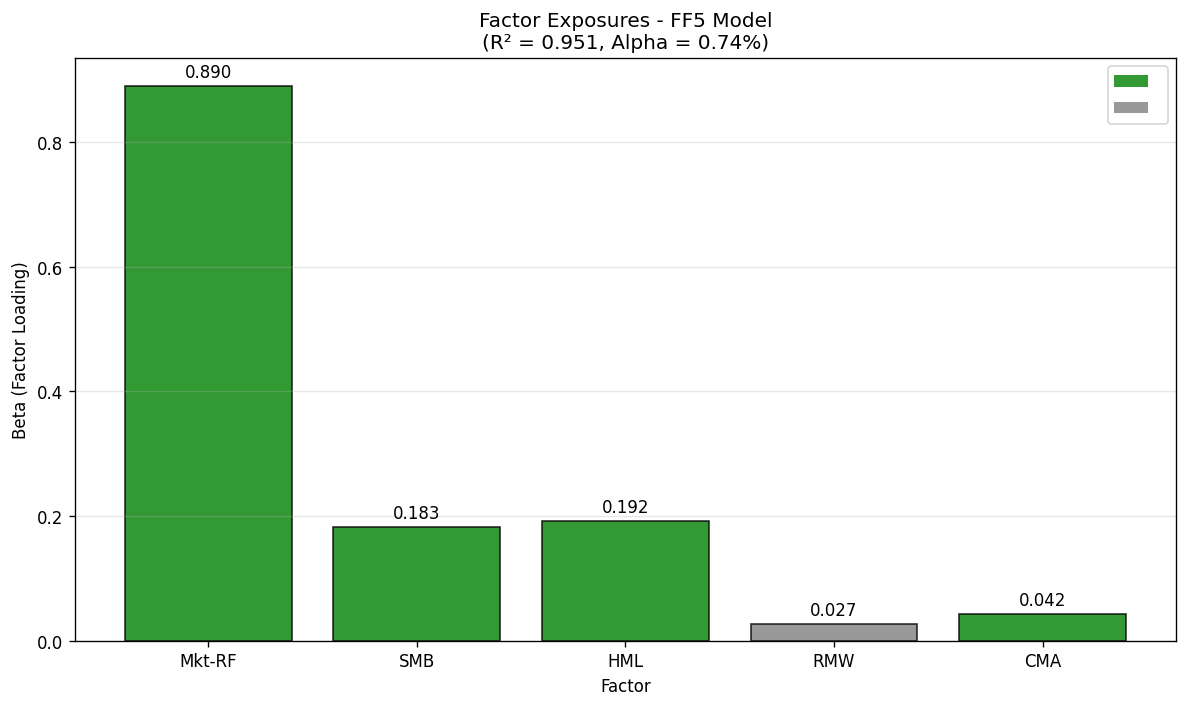

In [5]:
# Factor exposures bar chart - AVGE FF5
FactorVisualization.plot_factor_exposures(avge_ff5, figsize=(10, 6))

,Model,Alpha (%),Alpha p-value,R-squared,Adj R-squared,Mkt Beta,SMB,HML,RMW,CMA,MOM
0,CAPM,-0.3914,0.8883,0.8930,0.8929,0.8695,NaN,NaN,NaN,NaN,NaN
1,FF3,0.5987,0.7543,0.9499,0.9497,0.8855,0.1727,0.2107,NaN,NaN,NaN
2,FF5,0.7410,0.6972,0.9505,0.9502,0.8905,0.1832,0.1921,0.0266,0.0423,NaN
3,CARHART,0.6894,0.7160,0.9509,0.9507,0.8840,0.1550,0.2120,NaN,NaN,-0.0331


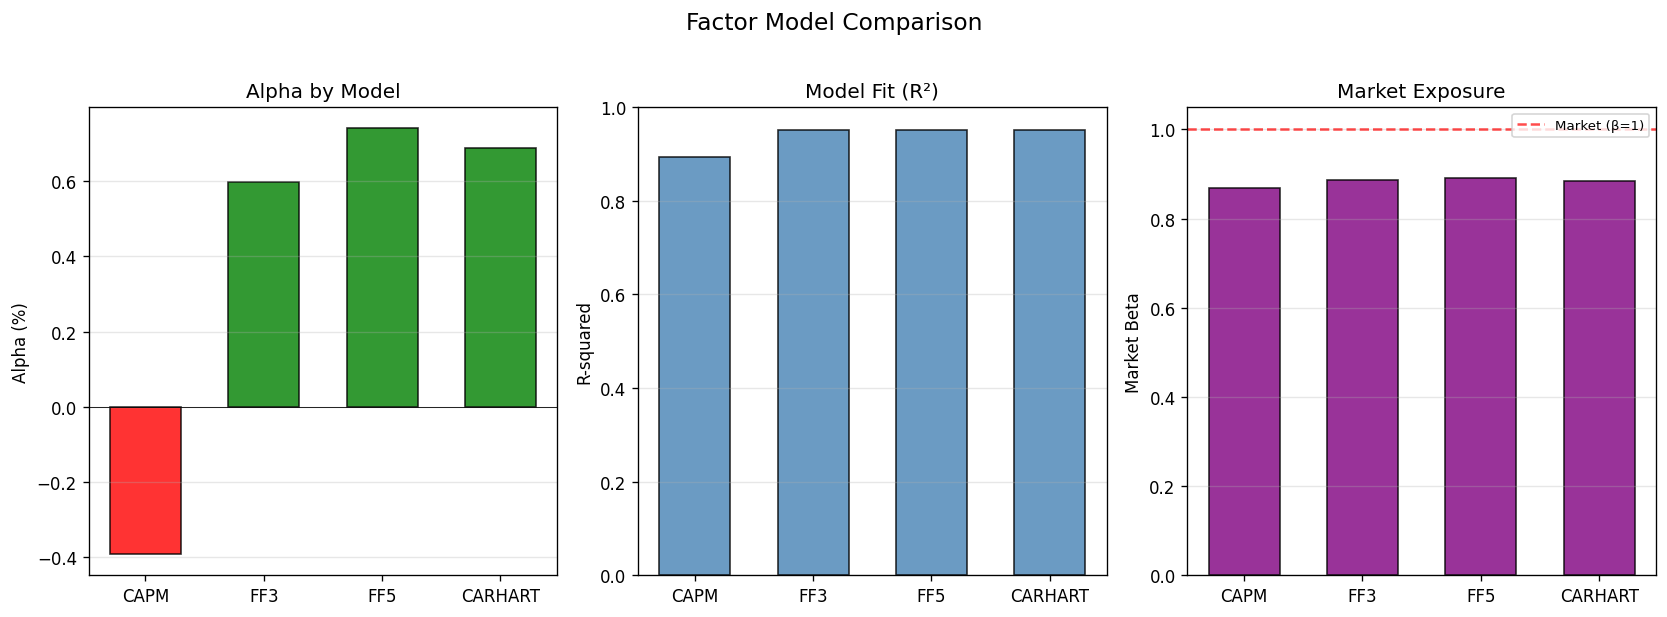

In [6]:
# Compare all models (CAPM, FF3, FF5, Carhart)
comparison_df = avge_reg.compare_models()
display(comparison_df.round(4))
FactorVisualization.plot_model_comparison(comparison_df, figsize=(14, 5))

## 3. Rolling Factor Exposures (AVGE)

How have factor loadings evolved over time? This uses a 120-day rolling window.

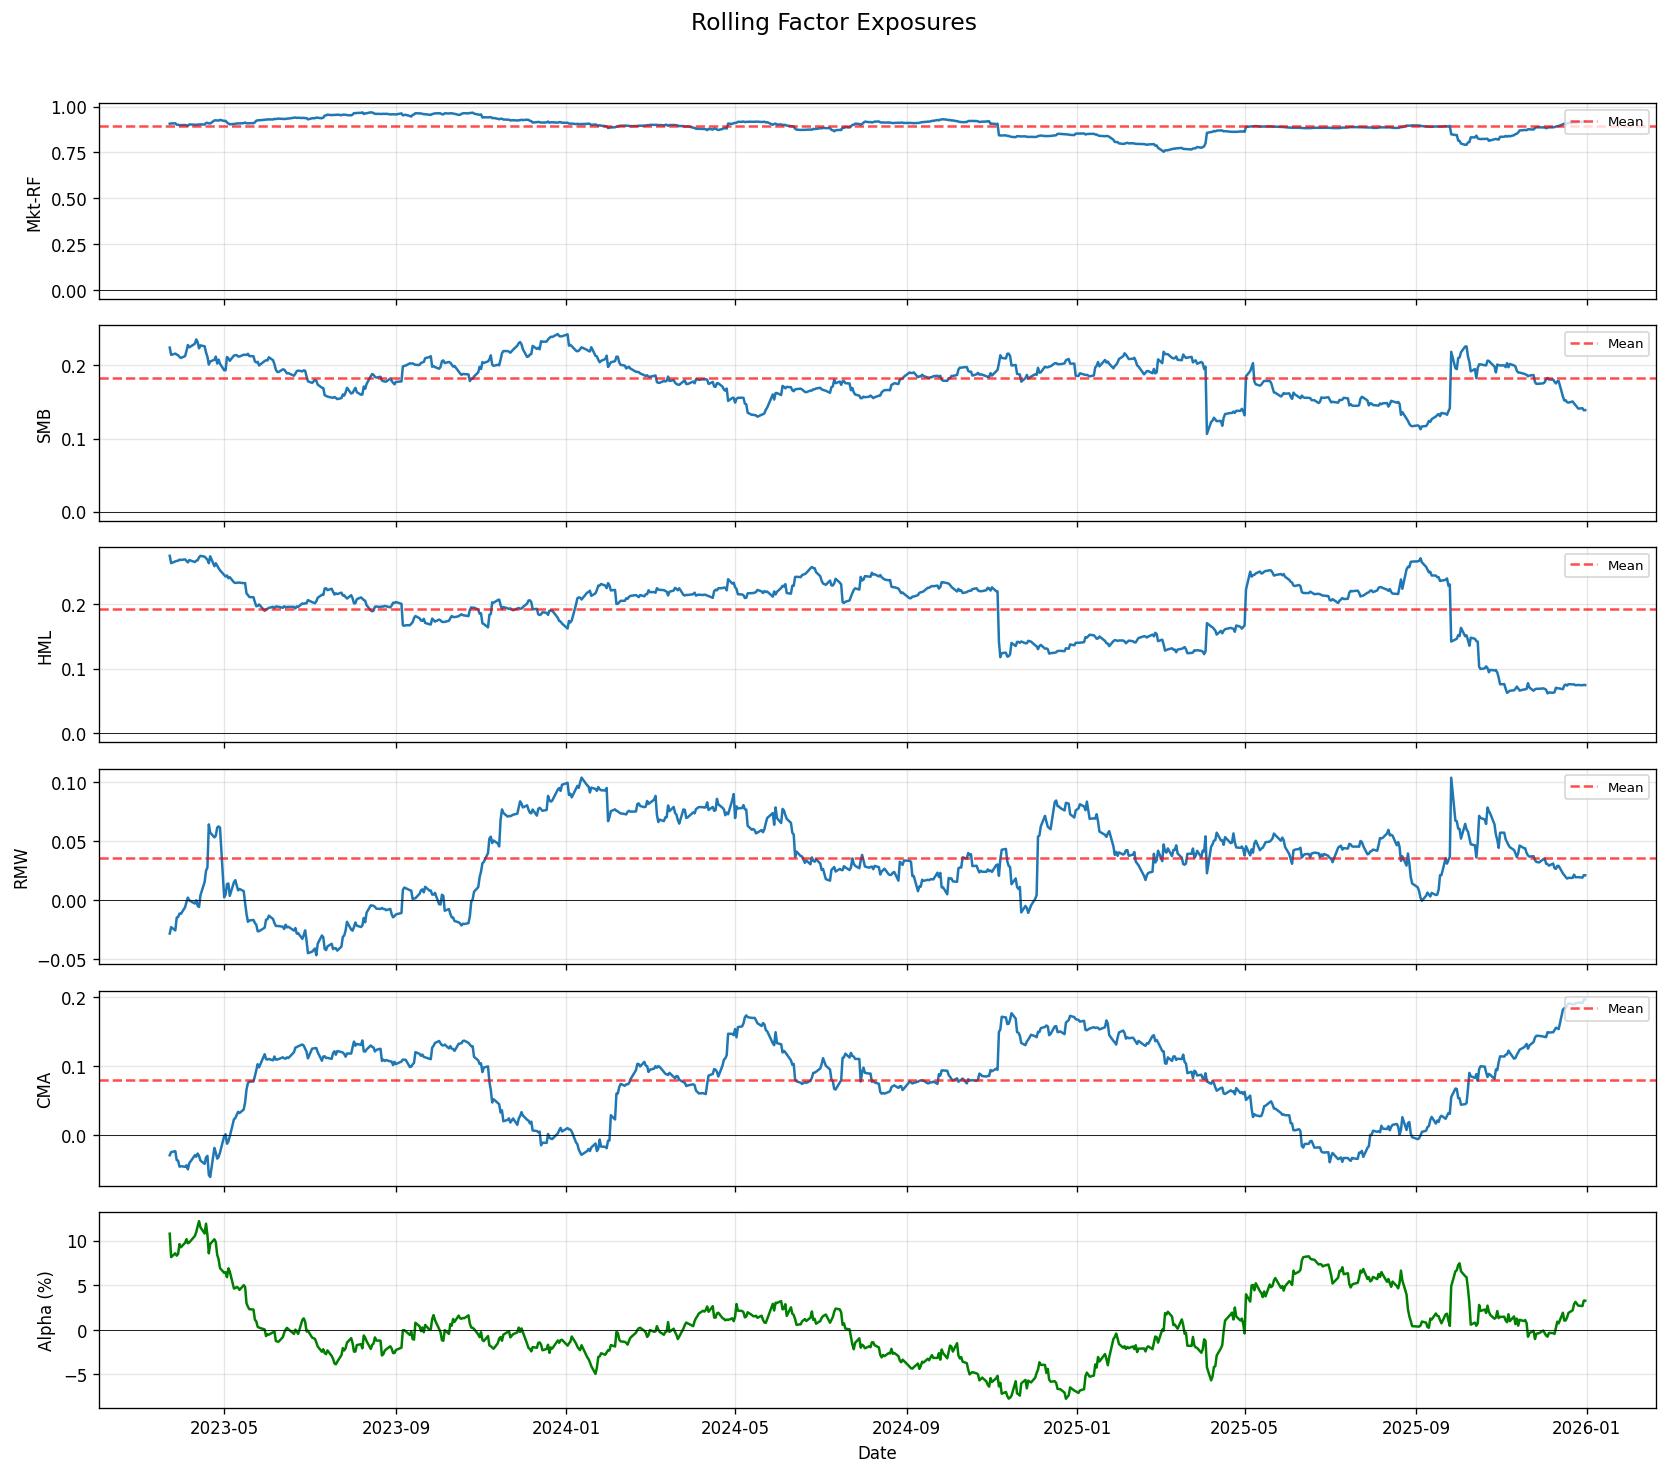

In [7]:
# Rolling FF5 betas (120-day window)
rolling_betas = avge_reg.run_rolling_regression('ff5', window=120)
FactorVisualization.plot_rolling_betas(rolling_betas, figsize=(14, 12))

## 4. Return & Risk Attribution (AVGE)

Decompose AVGE's returns and risk into factor contributions.

Return Decomposition (FF5, annualized):
  total          :    19.71%
  risk_free      :     4.91%
  Mkt-RF         :    15.56%
  SMB            :    -1.22%
  HML            :    -0.11%
  RMW            :     0.05%
  CMA            :    -0.22%
  alpha          :     0.74%


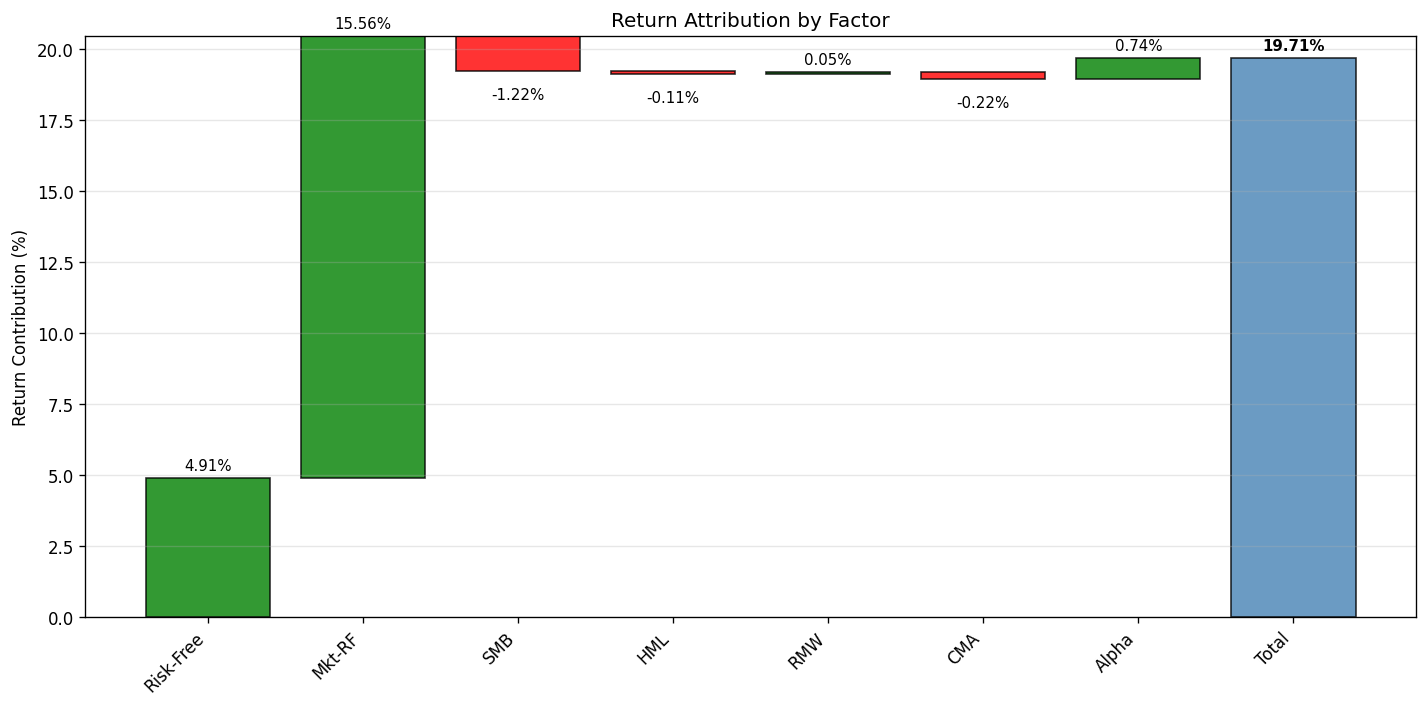

In [8]:
# Return attribution
avge_attr = FactorAttribution(avge_returns, factor_data)
return_decomp = avge_attr.decompose_returns('ff5')

print('Return Decomposition (FF5, annualized):')
for k, v in return_decomp.items():
    print(f'  {k:<15}: {v*100:>8.2f}%')

FactorVisualization.plot_return_attribution(return_decomp, figsize=(12, 6))

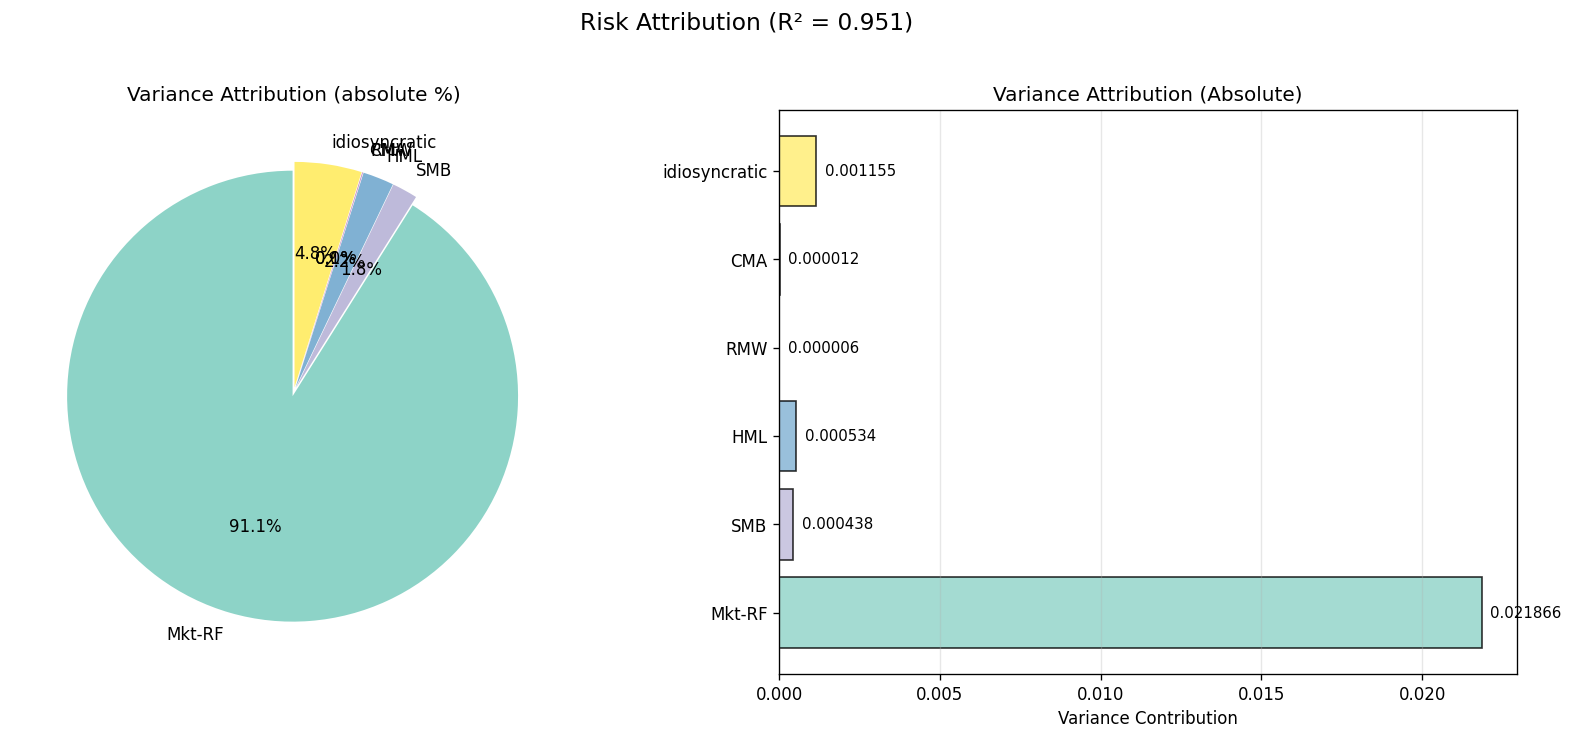

In [9]:
# Risk attribution
risk_decomp = avge_attr.decompose_risk('ff5')
FactorVisualization.plot_risk_attribution(risk_decomp, figsize=(14, 6))

In [10]:
# Full attribution summary table
summary_df = avge_attr.get_attribution_summary('ff5')
display(summary_df.round(4))

,Component,Return (%),Variance,Std Dev (%)
0,Total,19.7057,0.0233,15.2790
1,Risk-Free,4.9072,0.0000,0.0000
2,Mkt-RF,15.5569,0.0219,14.7872
3,SMB,-1.2161,0.0004,2.0930
4,HML,-0.1115,0.0005,2.3112
5,RMW,0.0468,0.0000,0.2380
6,CMA,-0.2186,0.0000,0.3513
7,Alpha (Idiosyncratic),0.7410,0.0012,3.3984


## 5. Underlying ETF Factor Loadings

Analyze each of AVTM's underlying Avantis ETFs to understand where factor tilts come from.

In [11]:
# Run FF5 regression on each underlying ETF
etf_results = {}
for ticker in AVGE_HOLDINGS:
    if ticker not in returns.columns:
        continue
    etf_ret = returns[ticker].dropna()
    if len(etf_ret) < 60:
        print(f'{ticker}: insufficient data ({len(etf_ret)} days), skipping')
        continue
    reg = FactorRegression(etf_ret, factor_data)
    etf_results[ticker] = reg.run_regression('ff5')

# Build comparison table
rows = []
for ticker, r in etf_results.items():
    rows.append({
        'Ticker': ticker,
        'Weight': f"{AVGE_HOLDINGS[ticker]:.1%}",
        'Alpha (%)': round(r.alpha * 100, 2),
        'Mkt-RF': round(r.betas['Mkt-RF'], 4),
        'SMB': round(r.betas['SMB'], 4),
        'HML': round(r.betas['HML'], 4),
        'RMW': round(r.betas['RMW'], 4),
        'CMA': round(r.betas['CMA'], 4),
        'R²': round(r.r_squared, 4),
    })

etf_df = pd.DataFrame(rows).set_index('Ticker')
display(etf_df)

,Weight,Alpha (%),Mkt-RF,SMB,HML,RMW,CMA,R²
Ticker,,,,,,,,
AVUS,41.9%,-1.11,1.0041,0.1176,0.1447,0.0584,0.0371,0.9908
AVLV,15.2%,-1.50,0.9758,0.1652,0.3348,0.1275,0.0280,0.9396
AVDE,11.1%,6.11,0.7221,0.0905,0.1452,-0.0376,0.0948,0.6280
AVEM,6.6%,5.46,0.6750,0.0852,-0.0592,-0.0964,0.1609,0.4911
AVIV,5.7%,7.15,0.7344,0.0874,0.2356,0.0044,0.0527,0.5954
AVUV,3.6%,-1.08,1.1026,0.8723,0.4864,0.2786,0.0075,0.9683
AVES,3.5%,5.34,0.5930,0.1117,0.0127,-0.0821,0.1193,0.4316
AVSC,3.4%,0.12,1.0069,0.9937,0.3159,0.0765,0.0362,0.9849
AVRE,2.8%,-4.54,0.6103,0.2369,0.2034,-0.1043,0.0350,0.4769


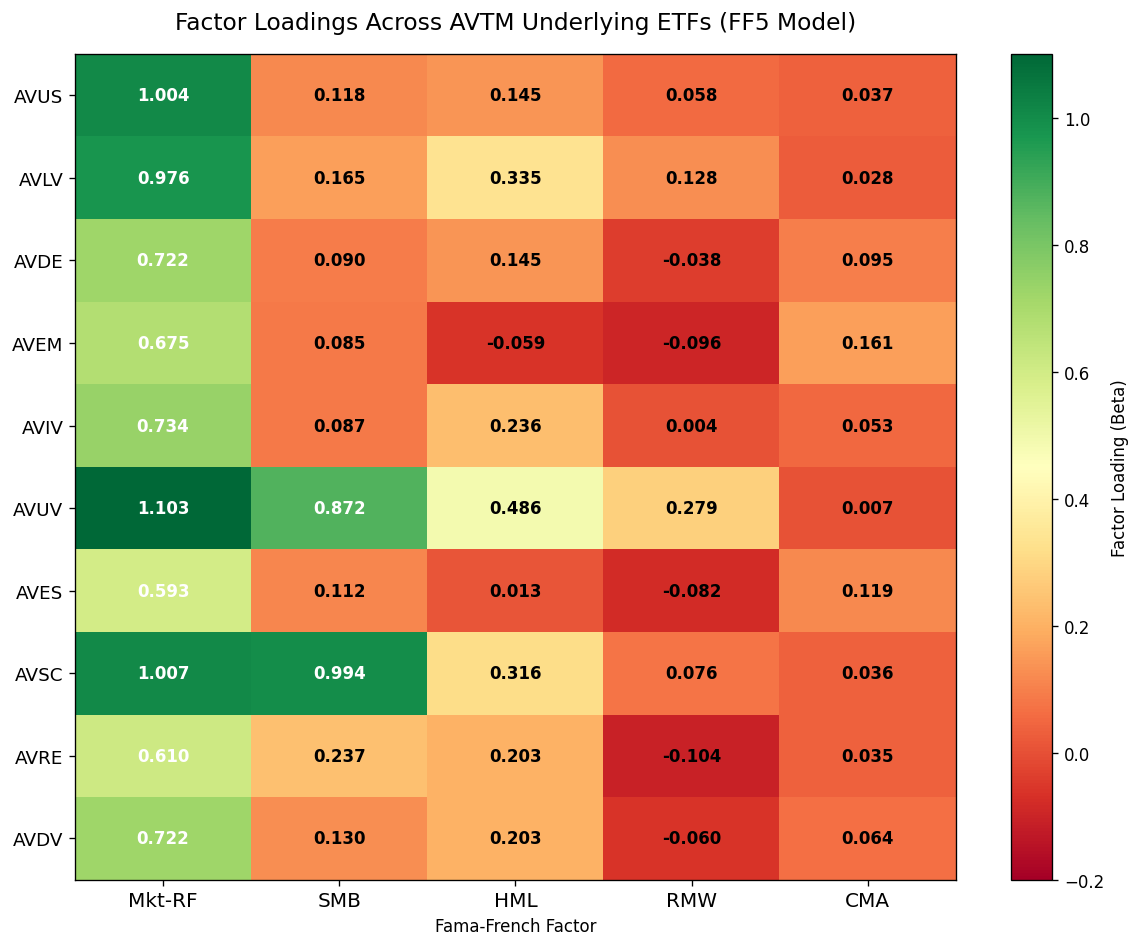

In [12]:
# Heatmap of factor loadings across all underlying ETFs
factors_to_plot = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
heatmap_data = etf_df[factors_to_plot].astype(float)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=-0.2, vmax=1.1)

# Labels
ax.set_xticks(range(len(factors_to_plot)))
ax.set_xticklabels(factors_to_plot, fontsize=12)
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index, fontsize=11)

# Add text annotations
for i in range(len(heatmap_data.index)):
    for j in range(len(factors_to_plot)):
        val = heatmap_data.iloc[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', fontsize=10, color=color, fontweight='bold')

plt.colorbar(im, ax=ax, label='Factor Loading (Beta)')
ax.set_title('Factor Loadings Across AVTM Underlying ETFs (FF5 Model)', fontsize=14, pad=15)
ax.set_xlabel('Fama-French Factor')
plt.tight_layout()
plt.show()

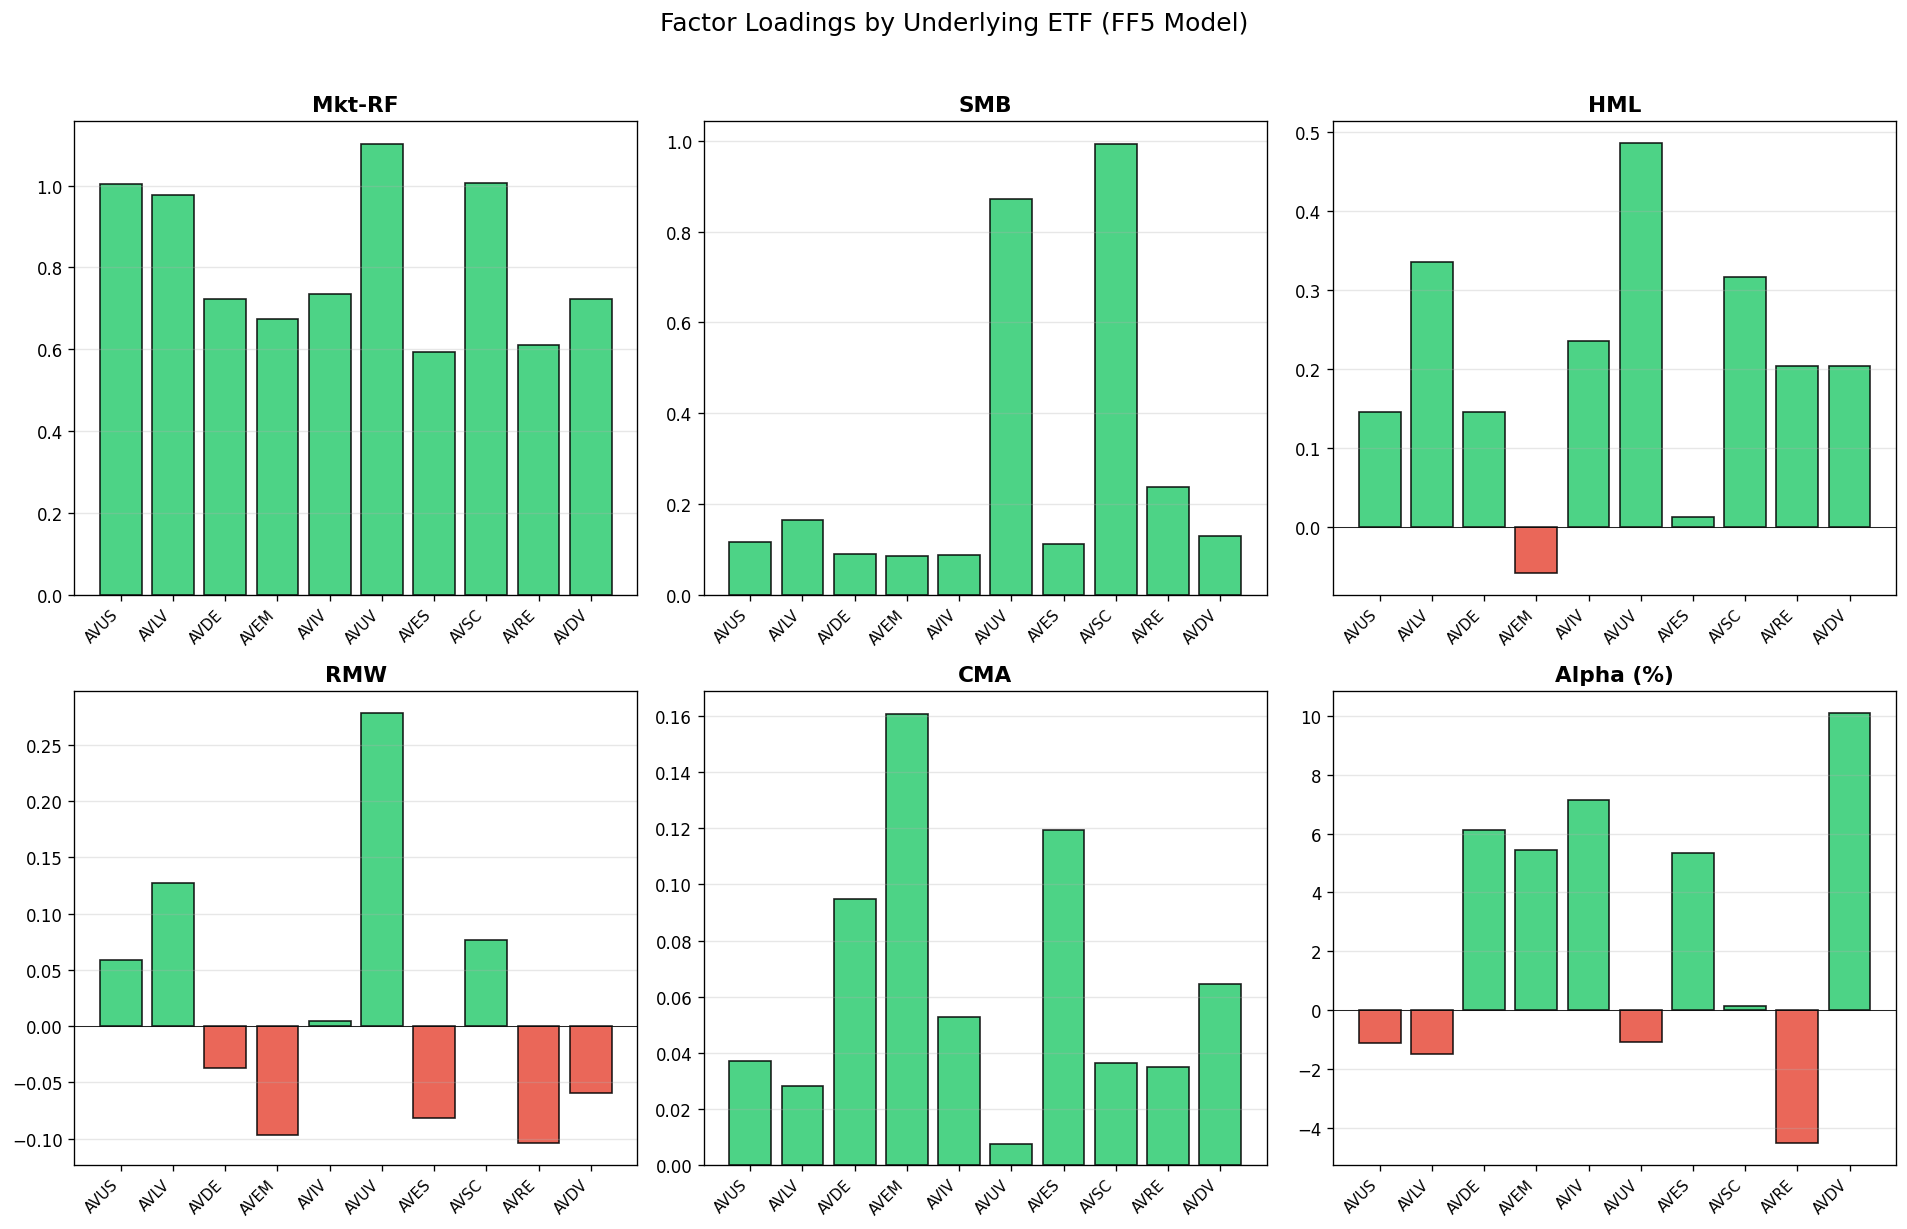

In [13]:
# Bar chart comparing factor loadings across ETFs
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
factors_with_alpha = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Alpha (%)']

for idx, factor in enumerate(factors_with_alpha):
    ax = axes[idx // 3][idx % 3]
    if factor == 'Alpha (%)':
        vals = etf_df['Alpha (%)'].astype(float)
    else:
        vals = etf_df[factor].astype(float)
    
    colors = ['#2ecc71' if v >= 0 else '#e74c3c' for v in vals]
    bars = ax.bar(range(len(vals)), vals, color=colors, edgecolor='black', alpha=0.85)
    ax.set_xticks(range(len(vals)))
    ax.set_xticklabels(vals.index, rotation=45, ha='right', fontsize=9)
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.set_title(factor, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Factor Loadings by Underlying ETF (FF5 Model)', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

## 6. Regional Factor Analysis (International ETFs)

The regressions in Section 5 used **US Fama-French factors** for all ETFs, including international ones. This produces low R² (0.43–0.63) and inflated spurious "alpha" for international holdings like AVDE, AVEM, AVES, and AVDV because US factors don't capture regional market, size, and value dynamics.

The Kenneth French Data Library provides regional factor datasets:
- **Developed ex-US factors** — for AVDE, AVIV, AVDV
- **Emerging-market factors** (monthly only) — for AVEM, AVES

We re-run regressions against proper regional factors and compare R² improvements.

In [ ]:
from portfolio_analysis.factors import CompositeFactorRegression

# Map international ETFs to their regional factor datasets
REGION_MAP = {
    'AVDE': 'developed_ex_us',
    'AVIV': 'developed_ex_us',
    'AVDV': 'developed_ex_us',
    'AVEM': 'emerging',
    'AVES': 'emerging',
}

# Build composite regression: US factors for domestic ETFs, regional for international
composite = CompositeFactorRegression(
    returns=returns[list(AVGE_HOLDINGS.keys())],
    portfolio_weights=AVGE_HOLDINGS,
    region_map=REGION_MAP,
    factor_loader=factor_loader,
    start_date=START_DATE,
    end_date=END_DATE,
)

composite_results = composite.run_composite_regression('ff5')
print(composite_results.summary())

In [ ]:
# Compare US-only vs regional factors for international ETFs
comparison = composite.compare_us_vs_regional('ff5')
print('US Factors vs Regional Factors — International ETFs')
display(comparison)

FactorVisualization.plot_regional_comparison(comparison)

In [ ]:
# Composite weighted factor exposures chart
FactorVisualization.plot_composite_exposures(composite_results)

## 7. Estimated AVTM Factor Loadings (US Factors Only)

Compute AVTM's estimated factor loadings as a weighted average of its underlying ETFs using US-only factor regressions from Section 5.

In [14]:
# Weighted-average factor loadings
weighted_betas = {}
weighted_alpha = 0.0
total_weight = 0.0

for ticker, weight in AVGE_HOLDINGS.items():
    if ticker not in etf_results:
        continue
    r = etf_results[ticker]
    total_weight += weight
    weighted_alpha += r.alpha * weight
    for factor in r.factors:
        weighted_betas[factor] = weighted_betas.get(factor, 0) + r.betas[factor] * weight

# Normalize
scale = 1.0 / total_weight
weighted_alpha *= scale
weighted_betas = {k: v * scale for k, v in weighted_betas.items()}

print(f'Coverage: {total_weight:.1%} of AVGE holdings analyzed')
print(f'\nEstimated AVTM Factor Loadings (FF5 Model):')
print(f'{"Factor":<10} {"Beta":>8}')
print('-' * 20)
for factor, beta in weighted_betas.items():
    print(f'{factor:<10} {beta:>8.4f}')
print(f'{"Alpha":<10} {weighted_alpha*100:>7.2f}%')

Coverage: 95.1% of AVGE holdings analyzed

Estimated AVTM Factor Loadings (FF5 Model):
Factor         Beta
--------------------
Mkt-RF       0.9010
SMB          0.1815
HML          0.1832
RMW          0.0417
CMA          0.0541
Alpha         0.96%


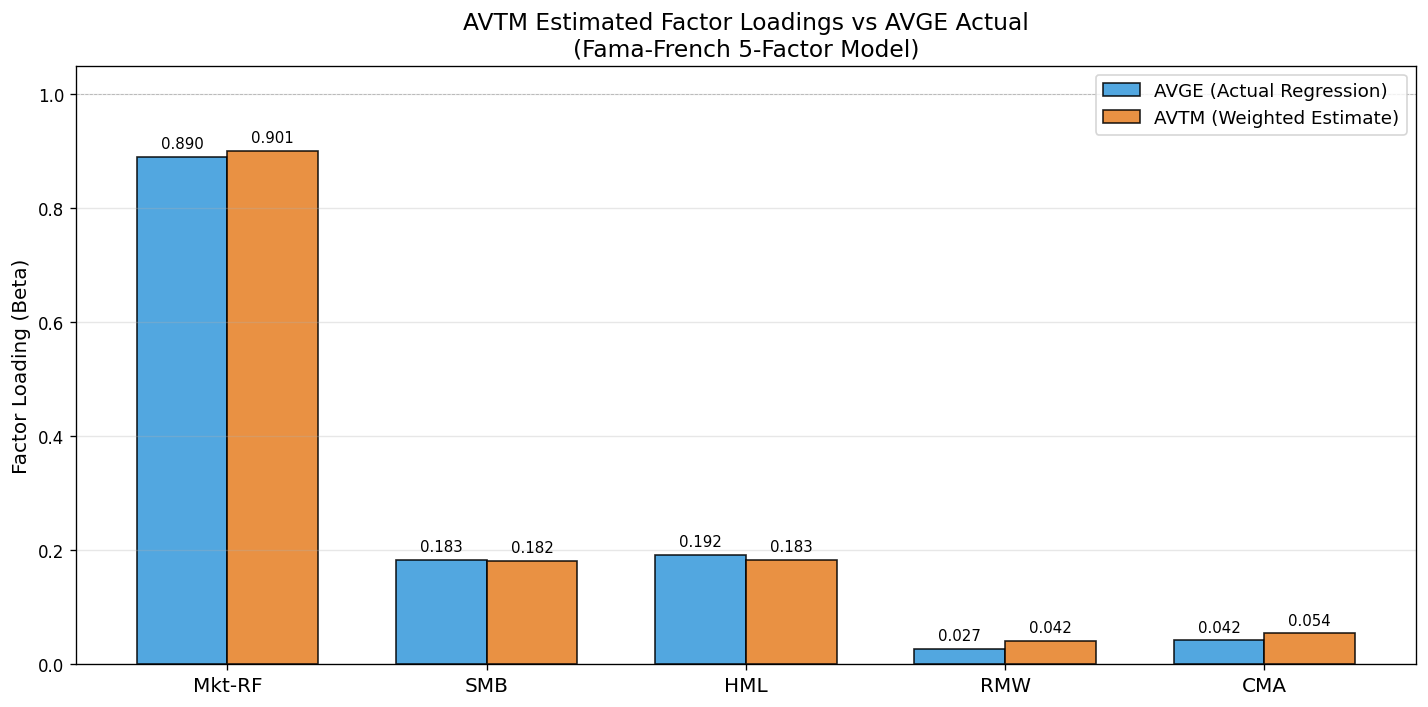

In [15]:
# Visualize estimated AVTM factor loadings vs AVGE actual
factors_list = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
avtm_est = [weighted_betas[f] for f in factors_list]
avge_actual = [avge_ff5.betas[f] for f in factors_list]

x = np.arange(len(factors_list))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, avge_actual, width, label='AVGE (Actual Regression)',
               color='#3498db', edgecolor='black', alpha=0.85)
bars2 = ax.bar(x + width/2, avtm_est, width, label='AVTM (Weighted Estimate)',
               color='#e67e22', edgecolor='black', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(factors_list, fontsize=12)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.axhline(y=1, color='gray', linewidth=0.5, linestyle='--', alpha=0.5)

# Value labels
for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f'{h:.3f}',
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f'{h:.3f}',
            ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Factor Loading (Beta)', fontsize=12)
ax.set_title('AVTM Estimated Factor Loadings vs AVGE Actual\n(Fama-French 5-Factor Model)', fontsize=14)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

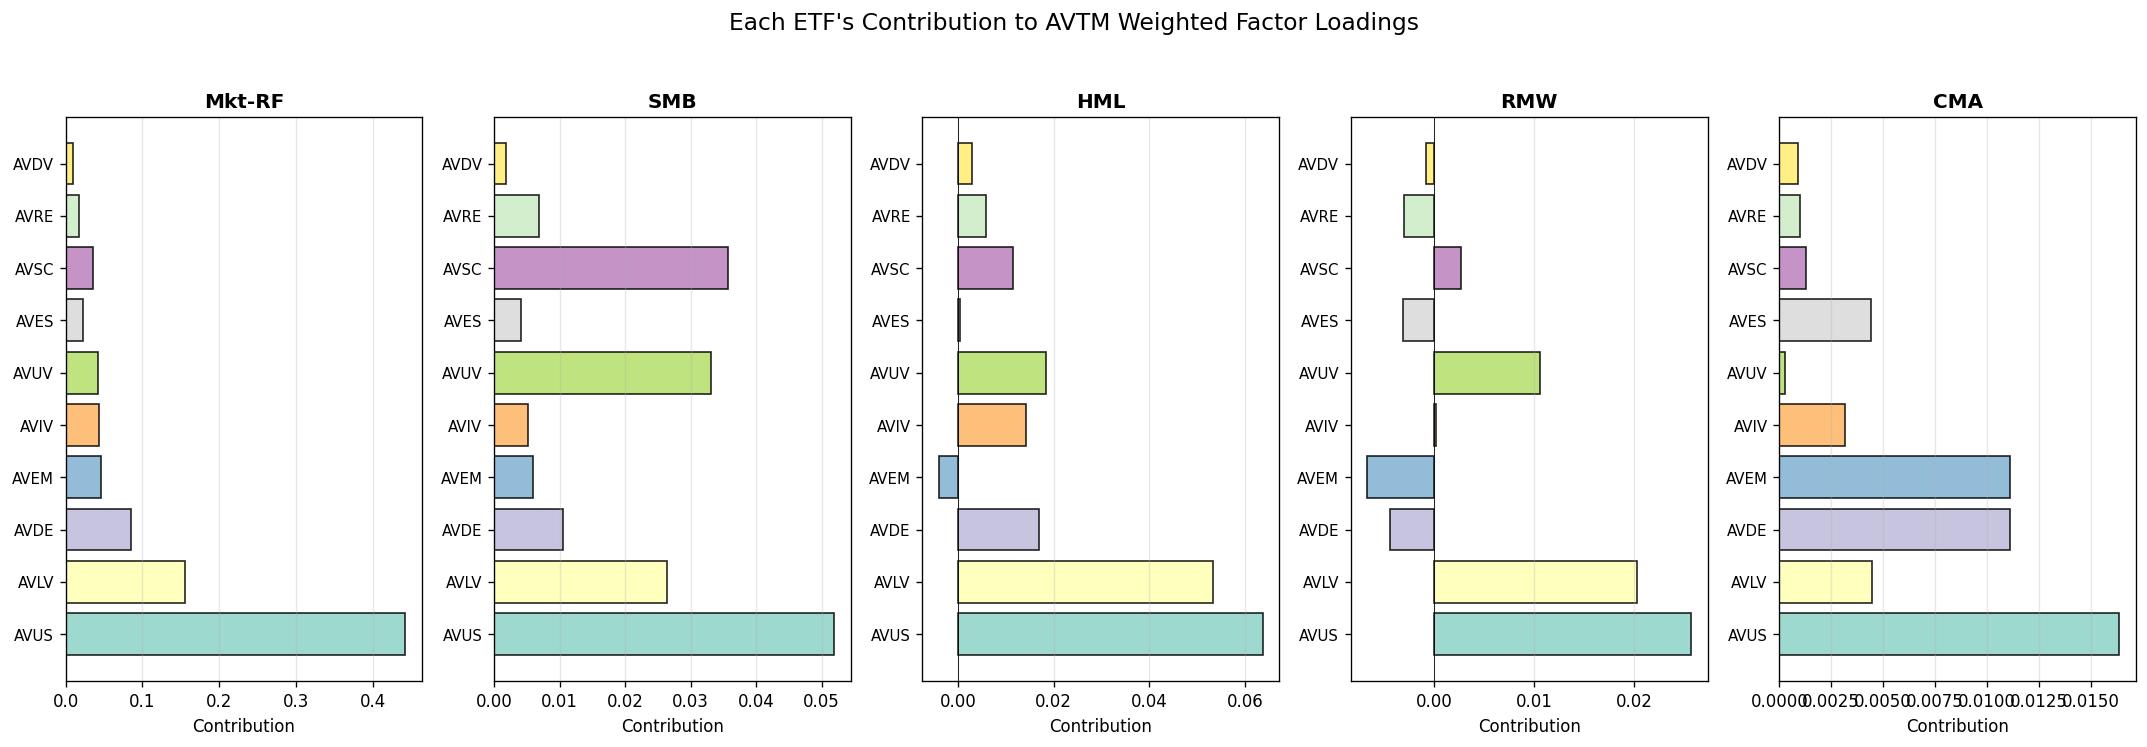

In [16]:
# Contribution of each ETF to the weighted betas (stacked)
fig, axes = plt.subplots(1, 5, figsize=(18, 6), sharey=False)

for idx, factor in enumerate(factors_list):
    ax = axes[idx]
    tickers = []
    contributions = []
    for ticker, weight in sorted(AVGE_HOLDINGS.items(), key=lambda x: x[1], reverse=True):
        if ticker not in etf_results:
            continue
        contrib = etf_results[ticker].betas[factor] * weight / total_weight
        tickers.append(ticker)
        contributions.append(contrib)

    colors = plt.cm.Set3(np.linspace(0, 1, len(tickers)))
    bars = ax.barh(range(len(tickers)), contributions, color=colors, edgecolor='black', alpha=0.85)
    ax.set_yticks(range(len(tickers)))
    ax.set_yticklabels(tickers, fontsize=9)
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_title(factor, fontsize=12, fontweight='bold')
    ax.set_xlabel('Contribution')
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Each ETF\'s Contribution to AVTM Weighted Factor Loadings', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

## 8. AVGE Detailed Factor Exposures (Individual Plots)

Visualize the top underlying ETFs' factor exposures individually.


--- AVUS ---


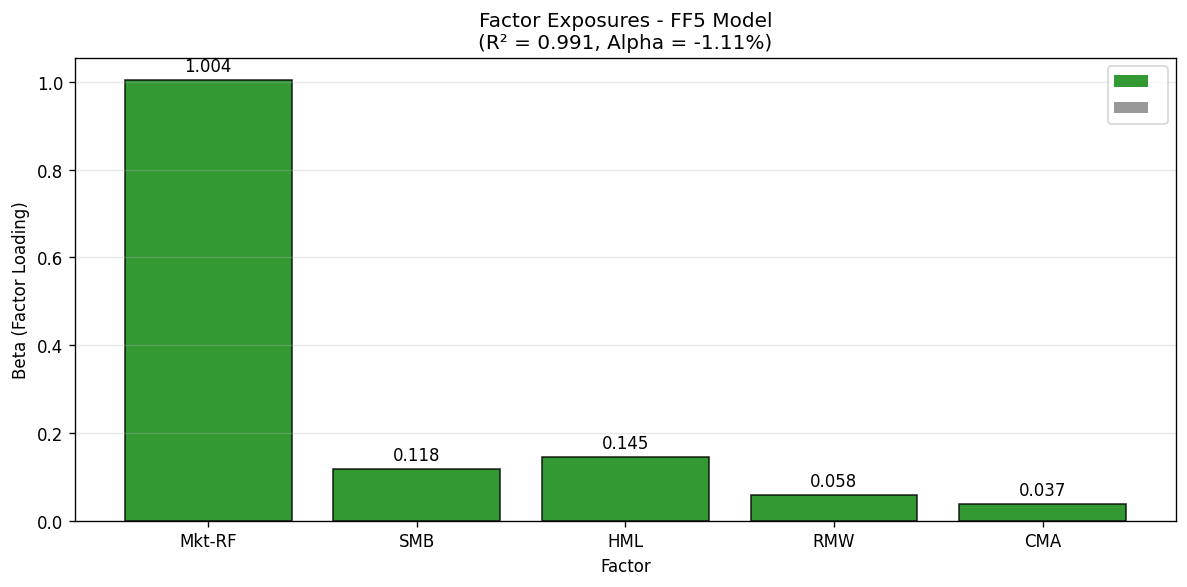


--- AVLV ---


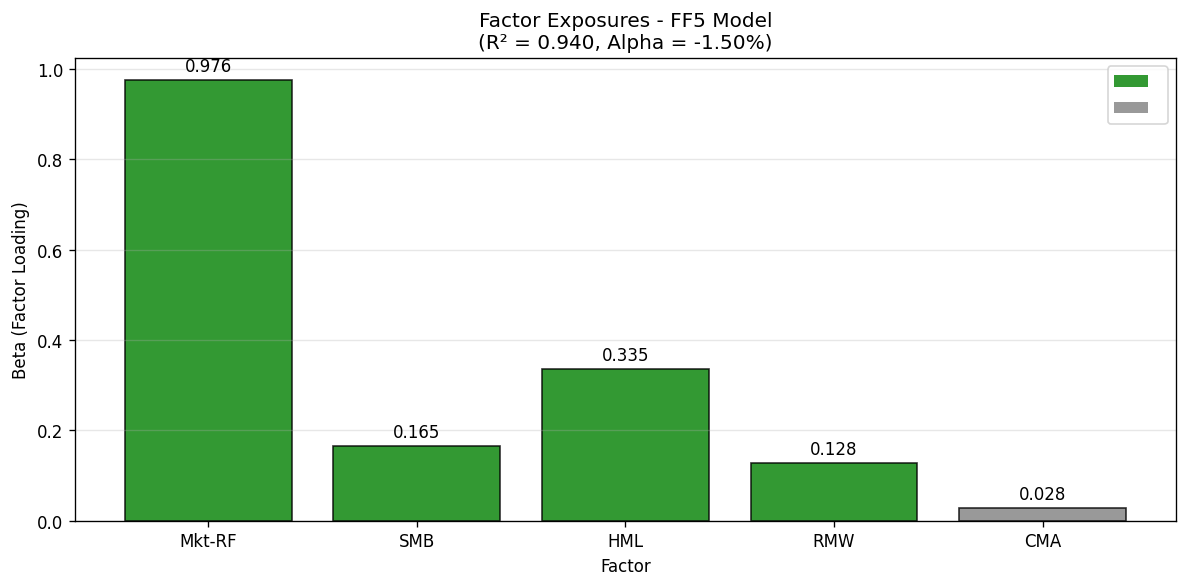


--- AVUV ---


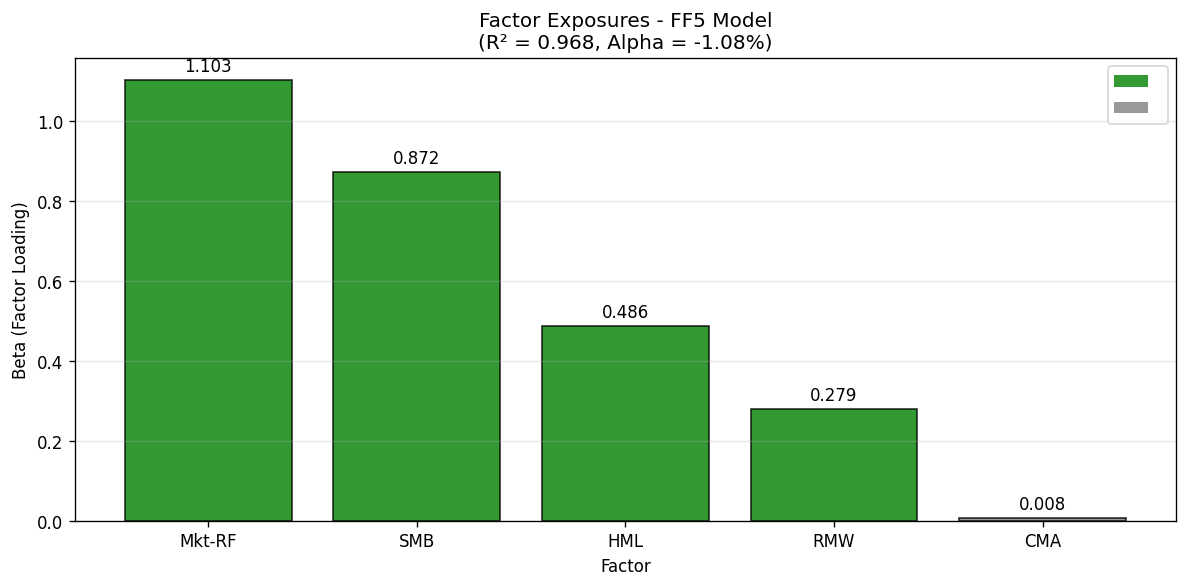


--- AVDV ---


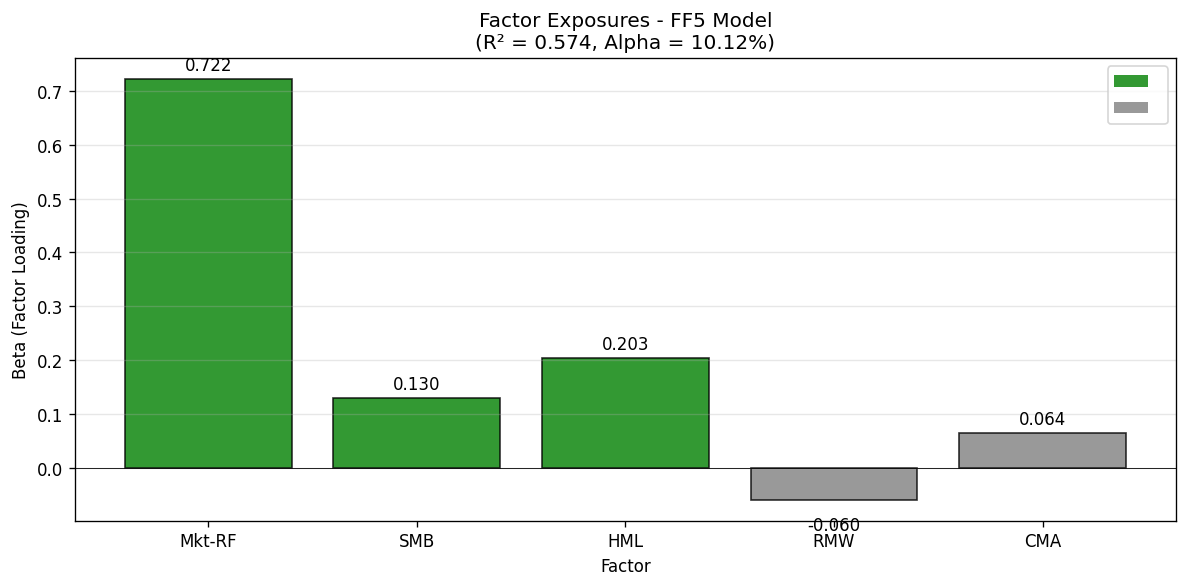

In [17]:
# Plot factor exposures for top 4 holdings
top_etfs = ['AVUS', 'AVLV', 'AVUV', 'AVDV']
for ticker in top_etfs:
    if ticker in etf_results:
        print(f'\n--- {ticker} ---')
        FactorVisualization.plot_factor_exposures(etf_results[ticker], figsize=(10, 5))

## 9. Summary

| Factor | AVTM Est. (US Only) | AVTM Est. (Composite) | Interpretation |
|--------|--------------------|-----------------------|----------------|
| **Mkt-RF** | ~0.90 | ~0.90 | Slightly defensive (int'l drag on US-based factor) |
| **SMB** | ~0.18 | varies | Meaningful small-cap tilt |
| **HML** | ~0.18 | varies | Meaningful value tilt |
| **RMW** | ~0.04 | varies | Neutral profitability |
| **CMA** | ~0.05 | varies | Neutral investment |

**Key Takeaways:**
- AVTM delivers **broad global equity exposure** with deliberate **value and small-cap tilts**
- The factor profile is nearly identical to AVGE, its fund-of-funds sibling
- ~94% of risk is explained by the market factor; factor tilts add diversified sources of expected return
- The strongest factor tilts come from **AVUV** (US Small Cap Value) and **AVLV** (US Large Cap Value)
- **Regional factors dramatically improve model fit for international ETFs** — R² increases substantially for AVDE, AVIV, AVDV, AVEM, and AVES when using developed ex-US and emerging-market factors
- Much of the apparent "alpha" in international ETFs (5-10% using US factors) is **spurious** — it shrinks considerably when regressed against the correct regional factors
- The composite global factor model (US factors for domestic, regional for international) provides **more accurate** AVTM factor loading estimates